<a href="https://colab.research.google.com/github/cassandraaaaaa/projetIA/blob/main/TP4_CNN__for_CIFAR_10_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Building a CNN to classify images in the CIFAR-10 Dataset

We will work with the CIFAR-10 Dataset.  This is a well-known dataset for image classification, which consists of 60000 32x32 color images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The 10 classes are:

<ol start="0">
<li> airplane
<li>  automobile
<li> bird
<li>  cat
<li> deer
<li> dog
<li>  frog
<li>  horse
<li>  ship
<li>  truck
</ol>

For details about CIFAR-10 see:
https://www.cs.toronto.edu/~kriz/cifar.html

For a compilation of published performance results on CIFAR 10, see:
http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html

---

### Building Convolutional Neural Nets

In this exercise we will build and train our first convolutional neural networks.  In the first part, we walk through the different layers and how they are configured.  In the second part, you will build your own model, train it, and compare the performance.

In [1]:
# new path configuration
import tensorflow as tf
print(tf.config.list_physical_devices())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
#import os
#NEW_PATH =r"C:/Users/96659/Desktop/deep_learning_projects"
#os.chdir(NEW_PATH)
#cwd = os.getcwd()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
Num GPUs Available:  0


In [2]:
# GPU use
import tensorflow as tf

if tf.config.list_physical_devices('GPU'):
    device = tf.device("/GPU:0")
    print("Training on GPU... Ready for HyperJump...")
else:
    device = tf.device("/CPU:0")
    print("Training on CPU... May the force be with you...")

Training on CPU... May the force be with you...


In [3]:
import keras
from keras.datasets import cifar100
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, ZeroPadding2D
from keras.layers import Conv2D, MaxPooling2D
import matplotlib.pyplot as plt
from matplotlib import pyplot


In [5]:
# The data, shuffled and split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar100.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print('y_train shape:', y_train.shape)
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
y_train shape: (50000, 1)
10000 test samples


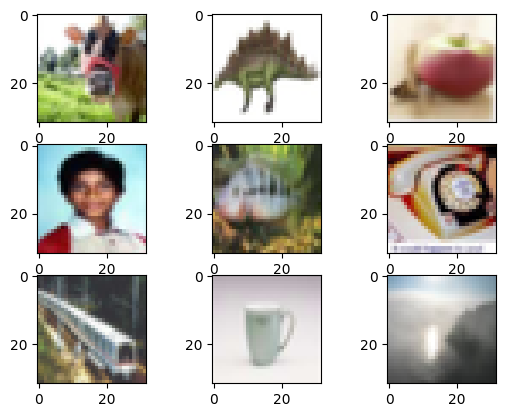

In [6]:
# plot first few images
for i in range(9):
 # define subplot
 pyplot.subplot(330 + 1 + i)
 # plot raw pixel data
 pyplot.imshow(x_train[i])
# show the figure
pyplot.show()

In [ ]:
num_classes = 100

y_train = keras.utils.to_categorical(y_train, num_classes) # One-hot encode labels
y_test = keras.utils.to_categorical(y_test, num_classes)# One-hot encode labels

In [ ]:
# now instead of classes described by an integer between 0-9 we have a vector with a 1 in the (Pythonic) 9th position
y_train[444]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [ ]:
# As before, let's make everything float and scale
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255  # Normalize pixel values to the range [0, 1]
x_test /= 255  # Normalize pixel values to the range [0, 1]

## Keras Layers for CNNs
- Previously we built Neural Networks using primarily the Dense, Activation and Dropout Layers.

- Here we will describe how to use some of the CNN-specific layers provided by Keras

### Conv2D

```python
keras.layers.convolutional.Conv2D(filters, kernel_size, strides=(1, 1), padding='valid', data_format=None, dilation_rate=(1, 1), activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None, **kwargs)
```

A few parameters explained:
- `filters`: the number of filter used per location.  In other words, the depth of the output.
- `kernel_size`: an (x,y) tuple giving the height and width of the kernel to be used
- `strides`: and (x,y) tuple giving the stride in each dimension.  Default is `(1,1)`
- `input_shape`: required only for the first layer

Note, the size of the output will be determined by the kernel_size, strides

### MaxPooling2D
`keras.layers.pooling.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)`

- `pool_size`: the (x,y) size of the grid to be pooled.
- `strides`: Assumed to be the `pool_size` unless otherwise specified

### Flatten
Turns its input into a one-dimensional vector (per instance).  Usually used when transitioning between convolutional layers and fully connected layers.

---

## 1- First CNN
Below we will build our first CNN.  For demonstration purposes (so that it will train quickly) it is not very deep and has relatively few parameters.  We use strides of 2 in the first two convolutional layers which quickly reduces the dimensions of the output.  After a MaxPooling layer, we flatten, and then have a single fully connected layer before our final classification layer.


### Epochs, batch, iterations
https://towardsdatascience.com/epoch-vs-iterations-vs-batch-size-4dfb9c7ce9c9
###### Epochs
One Epoch is when an ENTIRE dataset is passed forward and backward through the neural network only ONCE.
Since one epoch is too big to feed to the computer at once we divide it in several smaller batches.
we need to pass the full dataset multiple times to the same neural network.
we are using a limited dataset and to optimise the learning and the graph we are using Gradient Descent which is an iterative process. So, updating the weights with single pass or one epoch is not enough.

###### Batch Size
Total number of training examples present in a single batch.
you can’t pass the entire dataset into the neural net at once. So, you divide dataset into Number of Batches or sets or parts.

###### Iterations
Iterations is the number of batches needed to complete one epoch.

###### Loss   
https://www.baeldung.com/cs/ml-loss-accuracy
- If the errors are high, the loss will be high, which means that the model does not do a good job. Otherwise, the lower it is, the better our model works.
- If the loss value is not decreasing, but it just oscillates, the model might not be learning at all.
- However, if it’s decreasing in the training set but not in the validation set (or it decreases but there’s a notable difference), then the model might be overfitting

###### Accuracy
it measures how well our model predicts by comparing the model predictions with the true values in terms of percentage.
- Having a low accuracy but a high loss would mean that the model makes big errors in most of the data.
- if both loss and accuracy are low, it means the model makes small errors in most of the data
- if the accuracy is high and the loss is low, then the model makes small errors on just some of the data, which would be the ideal case.

In [ ]:
# Let's build a CNN using Keras' Sequential capabilities

# # # #  it is common for a convolutional layer to learn from 32 to 512 filters in parallel for a given input


model_1 = Sequential()


## 5x5 convolution with 2x2 stride and 32 filters
model_1.add(Conv2D(32, (5, 5), strides = (2,2), padding='same',input_shape=(32, 32, 3)))

## Another 5x5 convolution with 2x2 stride and 32 filters
model_1.add(Conv2D(32, (5, 5), strides = (2,2)))
model_1.add(Activation('relu'))

## 2x2 max pooling reduces to 3 x 3 x 32
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Dropout(0.25))

## Flatten turns 3x3x32 into 288x1
## Flatten layers are used when you got a multidimensional output and you want to make it linear to pass it onto a Dense layer
model_1.add(Flatten())
model_1.add(Dense(512))
model_1.add(Activation('relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(num_classes))
model_1.add(Activation('softmax'))

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 32)        2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 6, 6, 32)          25632     
                                                                 
 activation (Activation)     (None, 6, 6, 32)          0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 3, 3, 32)          0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 3, 3, 32)          0         
                                                                 
 flatten (Flatten)           (None, 288)               0         
                                                        

We still have 181K parameters, even though this is a "small" model.
epochs=
Batches=
iterations= numbers of batches needed to cpmlpete one batche


In [ ]:
batch_size = 32

# initiate RMSprop optimizer
opt = tf.keras.optimizers.legacy.RMSprop(learning_rate=0.0005, decay=1e-6)

# Let's train the model using RMSprop
model_1.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

model1=model_1.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=100,
              validation_data=(x_test, y_test),
              shuffle=True)
# it is better to use a separate validation dataset, e.g. by splitting the train dataset into train and validation sets.
# We will not split the data in this case, and instead use the test dataset as a validation dataset to keep the example simple.

Epoch 1/100
1563/1563 [==============================] - 34s 21ms/step - loss: 4.0404 - accuracy: 0.0881 - val_loss: 3.6337 - val_accuracy: 0.1566
Epoch 2/100
 586/1563 [==========>...................] - ETA: 18s - loss: 3.6186 - accuracy: 0.1545

KeyboardInterrupt: ignored

### 1-2 plot diagnostic learning curves
- the diagnostics involve creating a line plot showing model performance on the train and test set during training.
- these plots are valuable for getting an idea of whether a model is overfitting, underfitting, or has a good fit for the dataset.
- A good fit is identified by a training and validation loss that decreases to a point of stability with a minimal gap between the two final loss values.


In [ ]:
score, acc = model_1.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)
print('Test accuracy:', (acc * 100.0))

313/313 [==============================] - 2s 7ms/step - loss: 1.2200 - accuracy: 0.5972
Test score: 1.2200162410736084
Test accuracy: 0.5971999764442444
Test accuracy: 59.71999764442444


In [ ]:
# list all data in history
print(model1.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


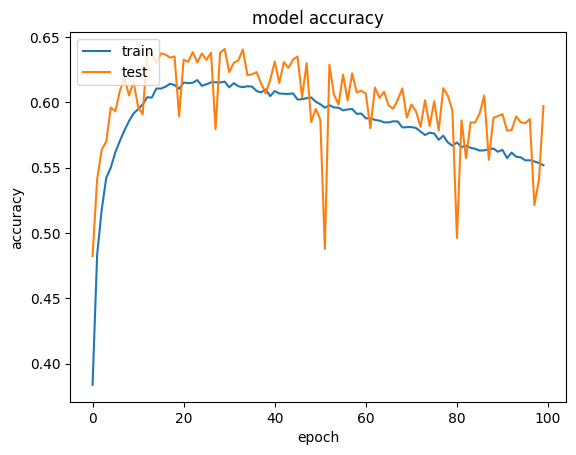

In [ ]:

# summarize history for accuracy
plt.plot(model1.history['accuracy'])
plt.plot(model1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

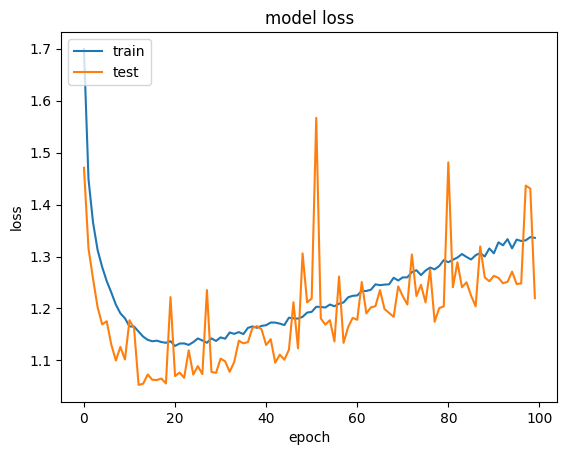

In [ ]:
# plot diagnostic learning curves
# summarize history for loss
plt.plot(model1.history['loss'])
plt.plot(model1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### 1-3 Grid Search Deep Learning Model Parameters

In [ ]:
def create_model():

    model= Sequential()


## 5x5 convolution with 2x2 stride and 32 filters
    model.add(Conv2D(32, (5, 5), strides = (2,2), padding='same',
                 input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))

## Another 5x5 convolution with 2x2 stride and 32 filters
    model.add(Conv2D(32, (5, 5), strides = (2,2)))
    model.add(Activation('relu'))

## 2x2 max pooling reduces to 3 x 3 x 32
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

## Flatten turns 3x3x32 into 288x1
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
    return model

In [ ]:
pip install scikeras

In [ ]:

from scikeras.wrappers import KerasClassifier
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV


# grid search epochs, batch size and optimizer

# # # # verbose is the choice that how you want to see the output of your Nural Network while
# # # # it's training. If you set verbose = 0, It will show nothing.

model = KerasClassifier(model=create_model, verbose=1)

print(model.get_params().keys())


# optimizers = ['rmsprop', 'adam']


epochs = [1, 10]
batches = [10, 20]

param_grid = dict(epochs=epochs, batch_size=batches)

# param_grid = dict(optimizer=optimizers, epochs=epochs, batch_size=batches)


grid = GridSearchCV(estimator=model, param_grid=param_grid)

grid_result = grid.fit(x_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


dict_keys(['model', 'build_fn', 'warm_start', 'random_state', 'optimizer', 'loss', 'metrics', 'batch_size', 'validation_batch_size', 'verbose', 'callbacks', 'validation_split', 'shuffle', 'run_eagerly', 'epochs', 'class_weight'])
1000/1000 [==============================] - 3s 3ms/step
Epoch 1/10
4000/4000 [==============================] - 34s 8ms/step - loss: 1.7488 - accuracy: 0.3628
Epoch 2/10
4000/4000 [==============================] - 33s 8ms/step - loss: 1.6100 - accuracy: 0.4306
Epoch 3/10
4000/4000 [==============================] - 34s 8ms/step - loss: 1.6296 - accuracy: 0.4306
Epoch 4/10
4000/4000 [==============================] - 33s 8ms/step - loss: 1.6393 - accuracy: 0.4319
Epoch 5/10
4000/4000 [==============================] - 33s 8ms/step - loss: 1.6754 - accuracy: 0.4218
Epoch 6/10
4000/4000 [==============================] - 34s 8ms/step - loss: 1.6965 - accuracy: 0.4155
Epoch 7/10
4000/4000 [==============================] - 33s 8ms/step - loss: 1.7270 - accuracy:

In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.099300 using {'batch_size': 20, 'epochs': 1}
0.097620 (0.002886) with: {'batch_size': 10, 'epochs': 1}
0.099160 (0.001155) with: {'batch_size': 10, 'epochs': 10}
0.099300 (0.001653) with: {'batch_size': 20, 'epochs': 1}
0.097500 (0.002286) with: {'batch_size': 20, 'epochs': 10}


## 2- Second CNN: VGG model
Our previous model had the structure:

Conv -> Conv -> MaxPool -> (Flatten) -> Dense -> Final Classification

(with appropriate activation functions and dropouts)

1. Build a more complicated model with the following pattern:
- Conv -> Conv -> MaxPool -> Conv -> Conv -> MaxPool -> (Flatten) -> Dense -> Final Classification

- Use strides of 1 for all convolutional layers.

2. How many parameters does your model have?  How does that compare to the previous model?

3. Train it for 5 epochs.  What do you notice about the training time, loss and accuracy numbers (on both the training and validation sets)?

5. Try different structures and run times, and see how accurate your model can be.


In [ ]:
# Let's build a CNN using Keras' Sequential capabilities

model_2 = Sequential()

model_2.add(Conv2D(32,(3, 3), padding='same', input_shape=x_train.shape[1:]))
model_2.add(Activation('relu'))
model_2.add(BatchNormalization())
model_2.add(Conv2D(32, (3, 3)))
model_2.add(Activation('relu'))
model_2.add(BatchNormalization())
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.5))
model_2.add(Conv2D(64, (3, 3), padding='same'))
model_2.add(Activation('relu'))
model_2.add(BatchNormalization())
model_2.add(Conv2D(64, (3, 3)))
model_2.add(Activation('relu'))
model_2.add(BatchNormalization())
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.5))
model_2.add(Conv2D(128, (3, 3), padding='same'))
model_2.add(Activation('relu'))
model_2.add(BatchNormalization())
model_2.add(Conv2D(128, (3, 3)))
model_2.add(Activation('relu'))
model_2.add(BatchNormalization())
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.5))
model_2.add(Flatten())
model_2.add(Dense(512))
model_2.add(Activation('relu'))
model_2.add(BatchNormalization())
model_2.add(Dropout(0.5))
model_2.add(Dense(num_classes))
model_2.add(Activation('softmax'))

In [ ]:
## Check number of parameters

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 activation_8 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 batch_normalization_7 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 activation_9 (Activation)   (None, 30, 30, 32)        0         
                                                                 
 batch_normalization_8 (Batc  (None, 30, 30, 32)       128       
 hNormalization)                                      

In [ ]:
# initiate RMSprop optimizer
opt_2 = keras.optimizers.RMSprop(learning_rate=0.0005)

# Let's train the model using RMSprop
model_2.compile(loss='categorical_crossentropy',
              optimizer=opt_2,
              metrics=['accuracy'])

In [ ]:
batch_size=32
model2=model_2.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=100,
              validation_data=(x_test, y_test),
              shuffle=True)

Epoch 1/100
1563/1563 [==============================] - 32s 19ms/step - loss: 2.0015 - accuracy: 0.3475 - val_loss: 1.5699 - val_accuracy: 0.4705
Epoch 2/100
1563/1563 [==============================] - 29s 18ms/step - loss: 1.3064 - accuracy: 0.5353 - val_loss: 1.4256 - val_accuracy: 0.5113
Epoch 3/100
1563/1563 [==============================] - 28s 18ms/step - loss: 1.1101 - accuracy: 0.6097 - val_loss: 0.9703 - val_accuracy: 0.6537
Epoch 4/100
1563/1563 [==============================] - 28s 18ms/step - loss: 0.9963 - accuracy: 0.6503 - val_loss: 0.8650 - val_accuracy: 0.6949
Epoch 5/100
1563/1563 [==============================] - 28s 18ms/step - loss: 0.9194 - accuracy: 0.6792 - val_loss: 0.8447 - val_accuracy: 0.7005
Epoch 6/100
1563/1563 [==============================] - 28s 18ms/step - loss: 0.8600 - accuracy: 0.7035 - val_loss: 0.7197 - val_accuracy: 0.7547
Epoch 7/100
1563/1563 [==============================] - 28s 18ms/step - loss: 0.8249 - accuracy: 0.7139 - val_loss: 0

In [ ]:
score, acc = model_2.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)
print('Test accuracy:', (acc * 100.0))

313/313 [==============================] - 3s 9ms/step - loss: 0.4352 - accuracy: 0.8578
Test score: 0.43516045808792114
Test accuracy: 0.8578000068664551
Test accuracy: 85.78000068664551


In [ ]:
print(model2.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


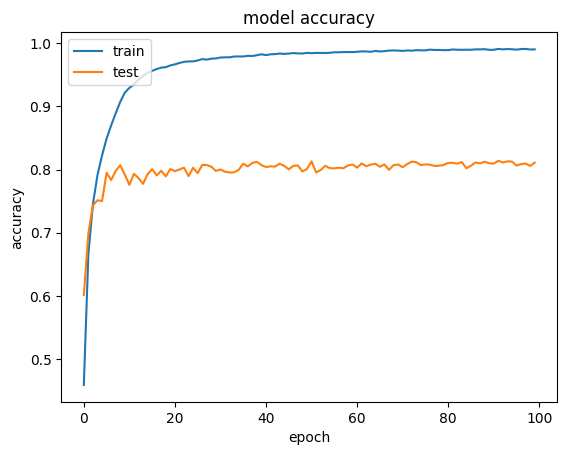

In [ ]:
# summarize history for accuracy
plt.plot(model2.history['accuracy'])
plt.plot(model2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

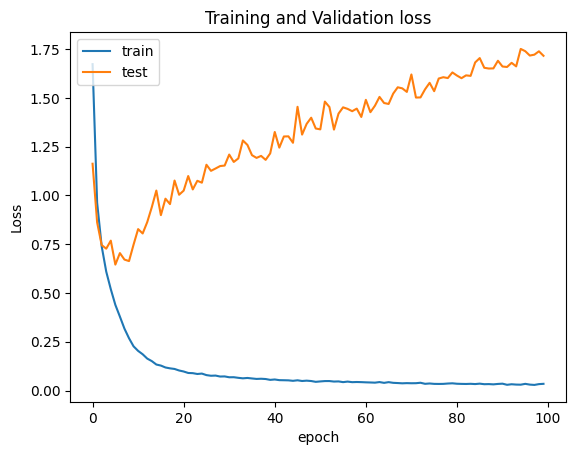

In [ ]:
# summarize history for accuracy
plt.plot(model2.history['loss'])
plt.plot(model2.history['val_loss'])
plt.title('Training and Validation loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# miniVGG

In [ ]:
model_3 = Sequential()

model_3.add(Conv2D(32,(3, 3), padding='same', input_shape=x_train.shape[1:]))
model_3.add(Activation('relu'))
model_3.add(BatchNormalization())
model_3.add(Conv2D(32, (3, 3)))
model_3.add(Activation('relu'))
model_3.add(BatchNormalization())
model_3.add(MaxPooling2D(pool_size=(2, 2)))
model_3.add(Dropout(0.25))
model_3.add(Conv2D(64, (3, 3), padding='same'))
model_3.add(Activation('relu'))
model_3.add(BatchNormalization())
model_3.add(Conv2D(64, (3, 3)))
model_3.add(Activation('relu'))
model_3.add(BatchNormalization())
model_3.add(MaxPooling2D(pool_size=(2, 2)))
model_3.add(Dropout(0.25))

model_3.add(Flatten())
model_3.add(Dense(512))
model_3.add(Activation('relu'))
model_3.add(BatchNormalization())
model_3.add(Dropout(0.5))
model_3.add(Dense(num_classes))
model_3.add(Activation('softmax'))

In [ ]:
model_3.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_41 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 activation_40 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 batch_normalization_35 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_42 (Conv2D)          (None, 30, 30, 32)        9248      
                                                                 
 activation_41 (Activation)  (None, 30, 30, 32)        0         
                                                                 
 batch_normalization_36 (Bat  (None, 30, 30, 32)       128       
 chNormalization)                                     

In [ ]:
# initiate RMSprop optimizer
opt_2 = keras.optimizers.RMSprop(learning_rate=0.0005)

# Let's train the model using RMSprop
model_3.compile(loss='categorical_crossentropy',
              optimizer=opt_2,
              metrics=['accuracy'])

In [ ]:
batch_size=32
model3=model_3.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=100,
              validation_data=(x_test, y_test),
              shuffle=True)

Epoch 1/100
1563/1563 [==============================] - 27s 16ms/step - loss: 1.6113 - accuracy: 0.4779 - val_loss: 1.1376 - val_accuracy: 0.6020
Epoch 2/100
1563/1563 [==============================] - 23s 15ms/step - loss: 1.0404 - accuracy: 0.6357 - val_loss: 0.8627 - val_accuracy: 0.7010
Epoch 3/100
1563/1563 [==============================] - 23s 15ms/step - loss: 0.8837 - accuracy: 0.6940 - val_loss: 0.8895 - val_accuracy: 0.6839
Epoch 4/100
1563/1563 [==============================] - 23s 15ms/step - loss: 0.7989 - accuracy: 0.7236 - val_loss: 0.8016 - val_accuracy: 0.7240
Epoch 5/100
1563/1563 [==============================] - 23s 15ms/step - loss: 0.7422 - accuracy: 0.7404 - val_loss: 0.7863 - val_accuracy: 0.7273
Epoch 6/100
1563/1563 [==============================] - 23s 15ms/step - loss: 0.6920 - accuracy: 0.7600 - val_loss: 0.6821 - val_accuracy: 0.7705
Epoch 7/100
1563/1563 [==============================] - 23s 15ms/step - loss: 0.6565 - accuracy: 0.7728 - val_loss: 0

In [ ]:
score, acc = model_3.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)
print('Test accuracy:', (acc * 100.0))

313/313 [==============================] - 1s 4ms/step - loss: 0.6201 - accuracy: 0.8403
Test score: 0.6200737357139587
Test accuracy: 0.8403000235557556
Test accuracy: 84.03000235557556


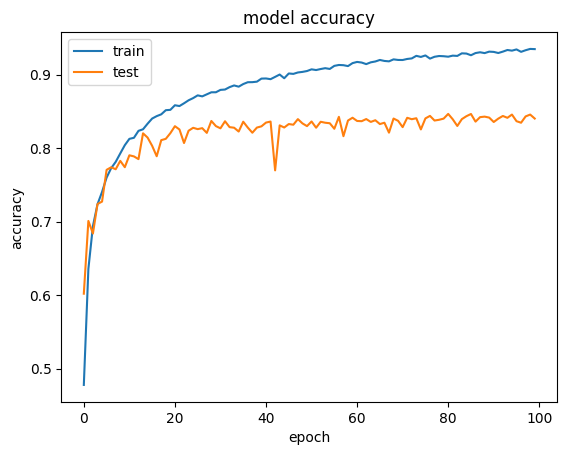

In [ ]:
# summarize history for accuracy
plt.plot(model3.history['accuracy'])
plt.plot(model3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

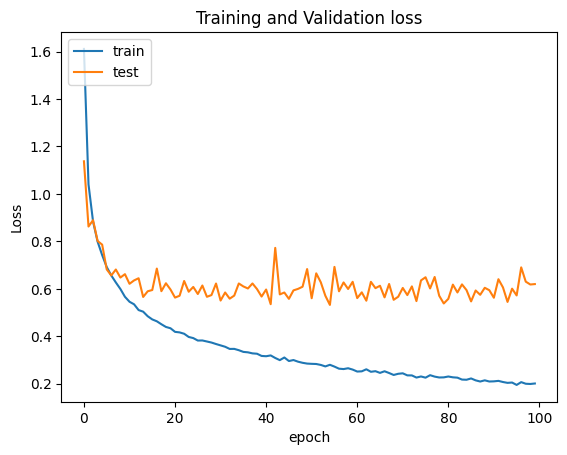

In [ ]:
# summarize history for accuracy
plt.plot(model3.history['loss'])
plt.plot(model3.history['val_loss'])
plt.title('Training and Validation loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

 # VGG19 | Transfer Learning ( colab file)

In [ ]:
 # Classical array manipulation
import numpy as np

# Image manipulation | OpenCV
import cv2

# Showing images and evaluating model results
import matplotlib.pyplot as plt

# VGG19 Model
from keras.applications.vgg19 import VGG19

# Preparing VGG19 Model
from keras.layers import Dense,Flatten,Input
from keras.models import Sequential

# One hot label encoding
from keras.utils import to_categorical

# CIFAR10 dataset
from keras.datasets import cifar10

In [ ]:
(x_train,y_train),(x_test,y_test) = cifar10.load_data()
print("Shape of x_train is ",x_train.shape)
print("Shape of y_train is ",y_train.shape)
print("Shape of x_test  is ",x_test.shape)
print("Shape of y_test  is",y_test.shape)


Shape of x_train is  (50000, 32, 32, 3)
Shape of y_train is  (50000, 1)
Shape of x_test  is  (10000, 32, 32, 3)
Shape of y_test  is (10000, 1)


In [ ]:
def resize_img(img):
    numberOfImage = img.shape[0]
    new_array = np.zeros((numberOfImage, 48,48,3))
    for i in range(numberOfImage):
        new_array[i] = cv2.resize(img[i,:,:,:],(48,48))
    return new_array

In [ ]:
x_train = resize_img(x_train)
x_test = resize_img(x_test)
print("New shape of x_train is ",x_train.shape)
print("New shape of x_test  is ",x_test.shape)

New shape of x_train is  (50000, 48, 48, 3)
New shape of x_test  is  (10000, 48, 48, 3)


In [ ]:
# one hot encoding
y_train = to_categorical(y_train,num_classes=10)
y_test = to_categorical(y_test,num_classes=10)

print("New shape of y_train is ",y_train.shape)
print("New shape of y_test  is ",y_test.shape)

New shape of y_train is  (50000, 10)
New shape of y_test  is  (10000, 10)


In [ ]:
# Include top = add fully connected layers to layer.
# Weights = use pretrained weights (trained in imagenet)
vgg = VGG19(include_top=False,weights="imagenet",input_shape=(48,48,3))

vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [ ]:
model = Sequential()

# Adding layers to the blank model
for layer in vgg.layers:
    model.add(layer)

# Don't train layers again, because they are already trained
for layer in model.layers:
    layer.trainable = False

# Adding fully connected layers
model.add(Flatten())
model.add(Dense(128))
model.add(Dense(10,activation="softmax"))

# Checking model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 12, 12, 256)       2

In [ ]:

# However before this, we need to compile the model
model.compile(optimizer="RMSprop",loss="categorical_crossentropy",metrics=["accuracy"])

# Let's train.
hist = model.fit(x_train,y_train,validation_split=0.15,epochs=20,batch_size=32)


InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.